Some imports just to render the results in colab

In [1]:

from gymnasium.wrappers import RecordVideo
import glob
import io
import base64
from IPython.display import HTML
from IPython import display

"""
Utility functions to enable video recording of gym environment
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")


We will work on the Lunar-Lander environment:

https://gymnasium.farama.org/environments/box2d/lunar_lander/

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

env = gym.make("LunarLander-v3", render_mode="human")

From the previous notebook, we can obtain the action and state space

In [4]:
print('Actions  : ',env.action_space)
print('Variables: ',env.observation_space)
print('Max. var: ',env.observation_space.high)
print('Min. var: ',env.observation_space.low)

Actions  :  Discrete(4)
Variables:  Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
Max. var:  [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ]
Min. var:  [-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ]


Variables correspond to position in x axis and speed. Actions correspond to forward and backward acceleration respectively.

Let's see performance of random behaviour

In [5]:
env.close()
env = RecordVideo(gym.make("LunarLander-v3",render_mode='rgb_array'),'video')

observation, _ = env.reset()

for _ in range(300):
  env.render()
  action = env.action_space.sample() # this takes random actions
  observation, reward, terminated , truncated, info = env.step(action)
  if terminated or truncated:
    break
env.close()
show_video()

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /content/video/rl-video-episode-0.mp4.
Moviepy - Writing video /content/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-0.mp4


# Q-learning with DNN

## Some definitions

1. Create the Q Neural Networks and initialize them


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Qvalue(nn.Module):
    def __init__(self, input, output):
      super(Qvalue, self).__init__()
      self.fc1 = nn.Linear(input, 64)
      self.fc2 = nn.Linear(64, 64)
      self.Q = nn.Linear(64, output)

    def forward(self, s):
      x = self.fc1(s)
      x = F.relu(x)
      x = self.fc2(x)
      x = F.relu(x)
      output = self.Q(x)

      return output

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.orthogonal_(m.weight)

def copy_target(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)

def soft_update(target_model, local_model, tau):
      for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
          target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


In [7]:
Q = Qvalue(env.observation_space.shape[0],env.action_space.n).to(device)
Q_target = Qvalue(env.observation_space.shape[0],env.action_space.n).to(device)

Q.apply(init_weights)  #

copy_target(Q_target, Q)  #

criterion=nn.MSELoss()
optimizer=torch.optim.Adam(Q.parameters(),lr=5e-4)


2. Definition of the Experience Replay buffer

In [8]:
import random
import numpy as np

class ReplayMemory:
    def __init__(self, capacity, seed):
        random.seed(seed)
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, terminated, truncated):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, terminated, truncated)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, min(len(self.buffer), batch_size))
        state, action, reward, next_state, terminated, truncated = map(np.stack, zip(*batch))
        return state, action, reward, next_state, terminated, truncated

    def __len__(self):
        return len(self.buffer)




Function that implements the epsilon-greedy procedure

In [9]:
def e_greedy_policy(Qs):
    return env.action_space.sample() if (np.random.random() <= epsilon) else np.argmax(Qs)


Function just to collect performance of *niter* iterations of the greedy plolicy (no exploration)

In [10]:
def rollout(niter):
    G = 0
    for i in range(niter):
        state, _ = env.reset()
        for _ in range(1000):
          Qs = Q(torch.tensor(state).to(device)).detach().cpu().numpy()
          action = np.argmax(Qs)
          next_state, reward, terminated , truncated, info = env.step(action)
          G += reward
          if truncated or terminated: break
          state = next_state
    return G/niter


## Start the learning

In [11]:
env.close()
env = gym.make("LunarLander-v3")


In [12]:
ER = ReplayMemory(int(1e6),1)

In [14]:
import time
t = time.time()

# Parameters of learning
gamma = 0.99
numEpisodes = 800   # 1000
epsilon = 1

# Variables to collect scores of 100 episodes
rewardTracker = [] # with exploration
scores_window = deque(maxlen=100)
all_rewards=[]

# NN parameters
batch_size=64
steps=0
for episodeNum in range(1,numEpisodes+1):
    G = 0
    state, _ = env.reset()

    while True:

        # Collect data
        with torch.no_grad():
          Qs = Q(torch.tensor(state).to(device)).detach().cpu().numpy()
          action = e_greedy_policy(Qs)  # select action with epsilon-greedy procedure
          next_state, reward, terminated , truncated, info = env.step(action)
          ER.push(state, action, reward, next_state, terminated, truncated)
          G= G+reward
          state = next_state
          steps=steps+1

        # Train
        if batch_size<=len(ER):
            # Get batch from exprience replay
            state_batch, action_batch, reward_batch, next_state_batch, terminated_batch, truncated_batch = ER.sample(batch_size)
            state_batch = torch.FloatTensor(state_batch).to(device)
            action_batch = torch.Tensor(action_batch).to(dtype=torch.long).to(device).unsqueeze(1)
            next_state_batch = torch.FloatTensor(next_state_batch).to(device)
            reward_batch = torch.FloatTensor(reward_batch).to(device).unsqueeze(1)
            terminated_batch = torch.FloatTensor(terminated_batch).to(dtype=torch.long).to(device).unsqueeze(1)
            truncated_batch = torch.FloatTensor(truncated_batch).to(dtype=torch.long).to(device).unsqueeze(1)

            #q_targets_next = torch.gather(Q_target(next_state_batch).detach(),1,torch.argmax(Q(next_state_batch).detach(),dim=1,keepdim = True))    # Double Q-learning
            q_targets_next = torch.max(Q_target(next_state_batch).detach(),dim=1,keepdim = True)[0]                                              # Standard DQN

            #target = reward_batch+  (1-(truncated_batch + terminated_batch)) *gamma*q_targets_next
            target = reward_batch+  (1-(terminated_batch)) *gamma*q_targets_next

            q_expected = torch.gather(Q(state_batch),1,action_batch)

            loss = criterion(q_expected, target)  #MSE
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            soft_update(Q_target, Q, 1e-3)

        if truncated or terminated: break

    scores_window.append(G)
    all_rewards.append(G)
    epsilon = max(0.01, 0.995*epsilon)
    print('\r episode:',episodeNum,'avg reward:', np.round(np.mean(scores_window),2),end='')

    if episodeNum%100==99:
      rewardTracker.append(np.mean(scores_window))
      print('\r episode:',episodeNum,'avg reward:', np.round(np.mean(scores_window),2), 'epsilon:', np.round(epsilon,2),'steps',steps)

elapsed = time.time() - t

print('\n elapsed', np.round(elapsed/60,2),'minutes')


 episode: 99 avg reward: -104.66 epsilon: 0.61 steps 9804
 episode: 199 avg reward: -22.83 epsilon: 0.37 steps 47752
 episode: 299 avg reward: 57.36 epsilon: 0.22 steps 125610
 episode: 399 avg reward: 151.07 epsilon: 0.14 steps 200650
 episode: 499 avg reward: 212.47 epsilon: 0.08 steps 254516
 episode: 599 avg reward: 188.89 epsilon: 0.05 steps 305507
 episode: 699 avg reward: 208.04 epsilon: 0.03 steps 351906
 episode: 700 avg reward: 208.08
 elapsed 20.92 minutes


See plots of learning. All rewards and average of 100 experiments

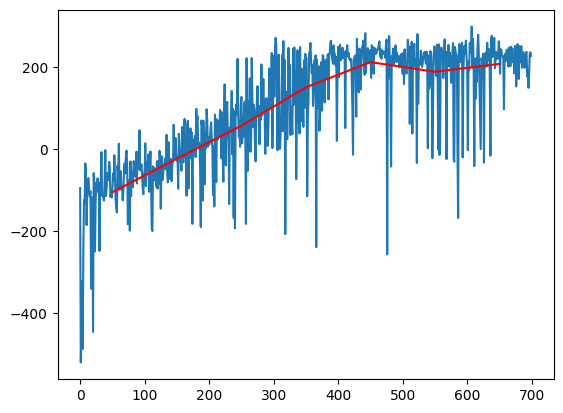

In [15]:
plt.plot(all_rewards)
plt.plot(list(range(50,(len(rewardTracker)+1)*100-50,100)),rewardTracker,color='r')
plt.show()

In [16]:
rollout(100)

179.6353845079027

## Let's see behaviour learnt

In [19]:
env.close()
env = RecordVideo(gym.make("LunarLander-v3",render_mode='rgb_array'),'video')

state, _ = env.reset()
while True:
    env.render()
    Qs = Q(torch.tensor(state).to(device)).detach().cpu().numpy()
    action = np.argmax(Qs)
    next_state, reward, terminated , truncated, info = env.step(action)
    if truncated or terminated: break
    state = next_state
env.close()
show_video()



Moviepy - Building video /content/video/rl-video-episode-0.mp4.
Moviepy - Writing video /content/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-0.mp4
